In [2]:
import numpy as np
import gym
import gym.spaces as spaces
import gym.envs as envs
import time
import matplotlib.pyplot as plt

### Helper functions

In [3]:
# Policy Analysis

def get_score(env, policy, episodes=1000):
    wins = 0
    loses = 0
    total_reward = 0
    steps = []
    sequence = []
    min_steps = np.Inf
    
    for i in range(episodes):
        done = False
        state = env.reset()
        cnt = 0
        seq_actions = []
        while True:
            action = policy[state]
            seq_actions.append(action)

            s_prime, r, done, _ = env.step(action)
            
            total_reward += r
            cnt += 1
            state = s_prime
            
            if done and r == 1.0:
                wins += 1
                steps.append(cnt)
                if cnt < min_steps:
                    min_steps = cnt
                    sequence = seq_actions
                break;
            elif done and r == 0.0:
                loses += 1
                break;
    
    print("Won Percentage = ", (wins/episodes) * 100)
    print("Lost Percentage = ", (loses/episodes) * 100)
    print("Average steps taken to win = ", np.mean(steps))
    print("Average reward in all episodes = ", total_reward/episodes)
    
    return wins, loses, steps, sequence

In [28]:
def map_actions(optimal_policy):
    policy = []
    for i in optimal_policy:
        if i == 0: # LEFT
            policy.append('\u2190')
        elif i == 1: # DOWN
            policy.append('\u2193')
        elif i == 2: # RIGHT
            policy.append('\u2192')
        elif i == 3: # UP
            policy.append('\u2191')
    return policy

### Value Iteration
- Procedure Value_Iteration(S,A,P,R,θ):
           Inputs
                     S is the set of all states
                     A is the set of all actions
                     P is state transition function specifying P(s'|s,a)
                     R is a reward function R(s,a,s')
                     θ a threshold, θ>0
           Output
                     π[S] approximately optimal policy
                    V[S] value function
           Local
                     real array Vk[S] is a sequence of value functions
                     action array π[S]
           assign V0[S] arbitrarily
           k ←0
           repeat
                     k ←k+1
                     for each state s do
                               Vk[s] = maxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk-1[s'])
           until ∀s |Vk[s]-Vk-1[s]| < θ
           for each state s do
                     π[s] = argmaxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk[s'])
           return π,Vk

In [5]:
def get_action_values(env, s, V, gamma=0.99):
    action_values = np.zeros(env.nA)
    
    for a in range(env.nA):
        for prob, s_prime, r, _ in env.P[s][a]:
            action_values[a] += prob * ( r + gamma * V[s_prime])
            
    return action_values

In [6]:
'''Value Iteration'''
def value_iteration(env, gamma = 0.999, max_iteration = 1000):
    # Initialise Utility Function
    V = np.zeros(env.nS)

    for i in range(max_iteration):
        prev_V = np.copy(V)

        #loop over all states
        for s in range(env.nS):
            action_values = get_action_values(env, s, prev_V, gamma)
            best_action_value = np.max(action_values)
            V[s] = best_action_value

        if i % 5 == 0 and np.all(np.isclose(V, prev_V)):
            print("Value converged at iteration ", i)
            break

    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    for s in range(env.nS):
        s_action_value = get_action_values(env, s, V, gamma)
        optimal_policy[s] = np.argmax(s_action_value)

    return V, optimal_policy

### Test Value Iteration 

Number of states:  16
Number of actions:  4

SFFF
FHFH
FFFH
HFFG
Value converged at iteration  335
Time to converge:  93.2 ms
Optimal Value function: 
[[0.785 0.778 0.774 0.771]
 [0.788 0.    0.506 0.   ]
 [0.792 0.8   0.745 0.   ]
 [0.    0.864 0.931 0.   ]]
Final Policy: 
[['←' '↑' '↑' '↑']
 ['←' '←' '←' '←']
 ['↑' '↓' '←' '←']
 ['←' '→' '↓' '←']]


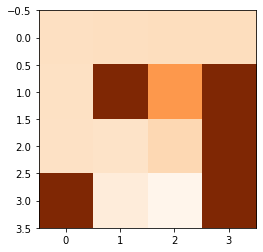

In [29]:
env = gym.make('FrozenLake-v0')
print("Number of states: ", env.nS)
print("Number of actions: ", env.nA)

env.render()

start_time = time.time()
optimal_value, optimal_policy = value_iteration(env.env, gamma=0.999, max_iteration=1000 )
stop_time = time.time()
time_taken = (stop_time - start_time)*1000

print (f"Time to converge: {time_taken : 0.3} ms")

print('Optimal Value function: ')
print(np.round(optimal_value, 3).reshape((4, 4)))

plt.figure(figsize=(4,4))
plt.imshow(optimal_value.reshape((4, 4)), cmap='Oranges_r')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy).reshape((4,4)))

In [18]:
wins, loses, steps, sequence = get_score(env, optimal_policy, episodes=1000)
print("Sequence of min steps taken: ", map_actions(sequence))
print("Min steps to win: ", len(sequence))

Won Percentage =  74.9
Lost Percentage =  25.1
Average steps taken to win =  38.308411214953274
Average reward in all episodes =  0.749
Sequence of min steps taken:  ['←', '↑', '↑', '↑', '←', '←', '←', '←', '↑', '↓', '←', '←', '←', '→', '↓', '←']
Min steps to win:  6


### Policy Iteration
The policy iteration algorithm manipulates the policy directly, rather than finding it indirectly via the optimal value function. It operates as follows:

<img src='http://incompleteideas.net/book/first/ebook/pseudotmp1.png'>
<img src='http://incompleteideas.net/book/first/ebook/imgtmp35.png'>

In [9]:
def get_policy_val(env, policy, V, gamma):
    policy_values = np.zeros(env.nS)
    for s, a in zip(range(len(policy)), policy):
        for prob, s_prime, r, _ in env.P[s][a]:
            policy_values[s] += prob * ( r + gamma * V[s_prime])
            
    return policy_values

In [10]:
def policy_iteration(env, gamma = 0.99, max_iteration = 1000):
    V = np.zeros(env.nS)
    
    P = np.random.randint(0, 4, env.nS)
    prev_P = np.copy(P)
    
    for i in range(max_iteration):
        
        V = get_policy_val(env, P, V, gamma)
        
        for s in range(env.nS):
            s_action_value = get_action_values(env, s, V, gamma)
            P[s] = np.argmax(s_action_value)
        
        if i % 10 == 0:
            if np.all(np.equal(P, prev_P)):
                print("Policy converged at iteration ", i)
                break
            prev_P = np.copy(P)
        
    return V, P

### Testing Policy Iteration

#### env2 = gym.make('FrozenLake-v0')
print("Number of states: ", env2.nS)
print("Number of actions: ", env2.nA)

env2.render()

start_time2 = time.time()
optimal_value2, optimal_policy2 = policy_iteration(env2.env, gamma=0.999, max_iteration=1000)
stop_time2 = time.time()
time_taken2 = (stop_time2 - start_time2) * 1000

print (f"Time to converge: {time_taken2 : 0.3} ms")

print('Optimal Value function: ')
print(np.round(optimal_value2, 3).reshape((4, 4)))
plt.figure(figsize=(4,4))
plt.imshow(optimal_value2.reshape((4, 4)), cmap='Oranges_r')

print('Final Policy: ')
policy2 = map_actions(optimal_policy2)

print(np.array(policy2).reshape((4,4)))

In [20]:
wins2, loses2, steps2, sequence2 = get_score(env2, optimal_policy2, episodes=1000)
print("Sequence of min steps taken: ", map_actions(sequence2))
print("Min steps to win: ", len(sequence2))

Won Percentage =  73.8
Lost Percentage =  26.200000000000003
Average steps taken to win =  37.56910569105691
Average reward in all episodes =  0.738
Sequence of min steps taken:  ['←', '↑', '↑', '↑', '←', '←', '←', '←', '↑', '↓', '←', '←', '←', '→', '↓', '←']
Min steps to win:  6


In [27]:
print(optimal_value.mean())
print(optimal_value2.mean())
print(len(np.where(optimal_value<=0.3)[0])/16)
(optimal_policy == optimal_policy2).reshape((4,4))

0.5333798903627254
0.3101127456459144
0.3125


array([[ True,  True, False,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

## Q- Learning

In [60]:
import random
import random as rand
env3 = gym.make('FrozenLake-v0')
action_size = env3.action_space.n
state_size = env3.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 100000        # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005

In [69]:
# List of rewards
rewards = []
start_time = time.time()

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env3.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env3.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env3.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

stop_time = time.time()
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print ("Time taken: ", (stop_time - start_time), " s.")
print(qtable)

Score over time: 0.34105
Time taken:  56.08213996887207  s.
[[4.58869585e-02 4.63198447e-01 4.65946075e-02 5.87087869e-02]
 [1.52177911e-04 1.53134331e-02 4.65081914e-04 2.39507947e-01]
 [1.46571877e-02 1.77730994e-03 4.57840318e-01 2.13433403e-02]
 [4.51596204e-03 1.79628926e-03 1.91378534e-02 9.10966733e-02]
 [1.94231408e-01 2.62701186e-04 1.27238612e-02 3.49117862e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.70822632e-04 5.42621156e-05 9.70650024e-02 6.15396670e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.80602096e-02 3.30168576e-03 2.81900053e-02 3.84971772e-01]
 [4.93386983e-04 7.98984608e-01 9.50425459e-03 6.10996064e-03]
 [6.67908466e-01 2.98995042e-02 1.14842317e-03 2.69270070e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.94873539e-01 4.28104822e-02 9.34198851e-01 1.02886501e-01]
 [2.07744937e-01 9.76838564e-01 2.75411061e-01 2.17651553e

Optimal Value function: 
[[0.463 0.24  0.458 0.091]
 [0.194 0.    0.097 0.   ]
 [0.385 0.799 0.668 0.   ]
 [0.    0.934 0.977 0.   ]]
Final Policy: 
[['↓' '↑' '→' '↑']
 ['←' '←' '→' '←']
 ['↑' '↓' '←' '←']
 ['←' '→' '↓' '←']]


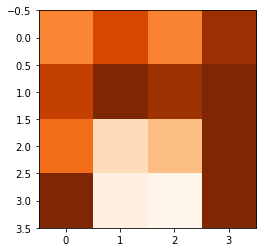

In [73]:
optimal_policy3 = np.argmax(qtable, axis=1)
optimal_value3 = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value3, 3).reshape((4, 4)))
plt.figure(figsize=(4,4))
plt.imshow(optimal_value3.reshape((4, 4)), cmap='Oranges_r')

print('Final Policy: ')
policy3 = map_actions(optimal_policy3)

print(np.array(policy3).reshape((4,4)))

In [71]:
wins3, loses3, steps3, sequence3 = get_score(env3, optimal_policy3, episodes=1000)
print("Sequence of min steps taken: ", map_actions(sequence3))
print("Min steps to win: ", len(sequence3))

Won Percentage =  46.800000000000004
Lost Percentage =  53.2
Average steps taken to win =  28.48931623931624
Average reward in all episodes =  0.468
Sequence of min steps taken:  ['↓', '↑', '→', '→', '←', '↓']
Min steps to win:  6


In [72]:
import pandas as pd
pd.DataFrame(np.round(optimal_value3, 3).reshape((4,4))).to_csv('b.csv')